In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

import math
from sklearn.metrics import  mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

from sklearn.preprocessing import PolynomialFeatures

C:\Users\Виктория\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Преобразование Бокса-Кокса

Если случайная величина имеет логнормальное распределение, то ее логарифм имеет нормальное распределение.

In [2]:
data_log = pd.Series(np.random.lognormal(0, 1, 1000))

<Axes: >

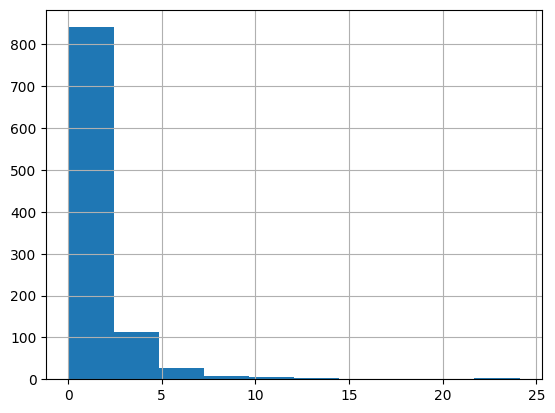

In [3]:
data_log.hist()

<Axes: >

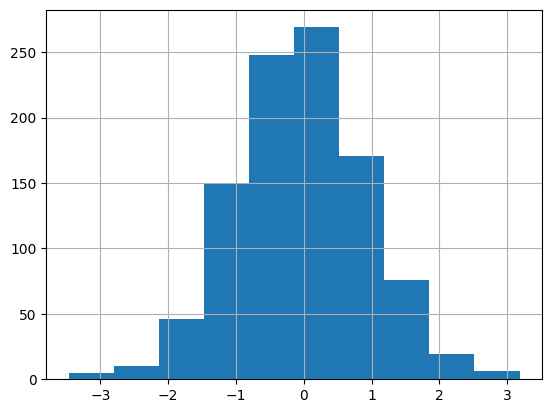

In [4]:
np.log(data_log).hist()

Почему это работает?

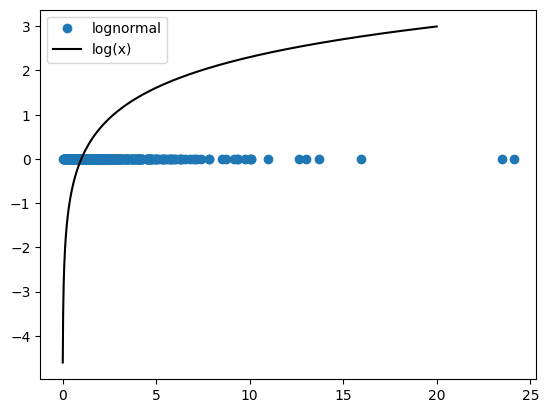

In [5]:
log_x = np.arange(0.01, 20, 0.01)
log_y = np.log(log_x)

x_points = data_log
y_points = np.zeros(1000)

fig = plt.figure()
plt.plot(x_points, y_points, 'o', label="lognormal")
plt.plot(log_x, log_y, 'black', label='log(x)')

plt.legend()

#fig.show()

Синий цвет - наблюдения (из гистограммы). Черное - "накинули" логарифм на точки. Применение логарифма приводит к нормальному распределению. Слева от пересечения - точки растягиваются вниз. Справа: выбираем 2 икса (расстояние между ними большое) - перпендикуляр на F - перпендикуляр на ось Y (расстояние маленькое)

Если экспоненциальное распределение?

In [6]:
data_exp = pd.Series(np.random.exponential(size=1000))

<Axes: >

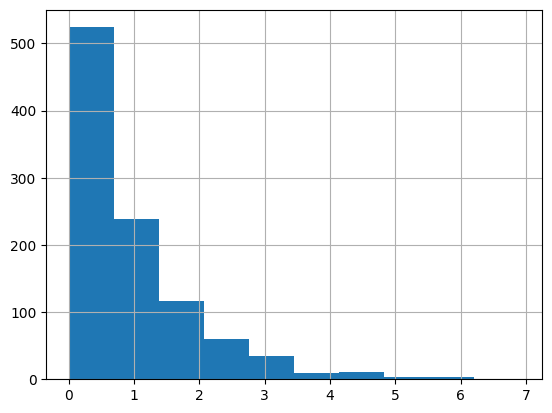

In [7]:
data_exp.hist()

<Axes: >

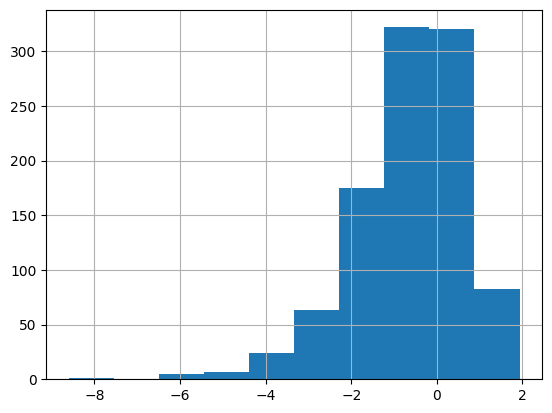

In [8]:
np.log(data_exp).hist()

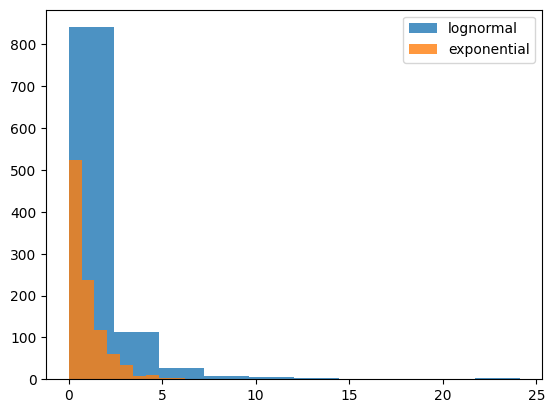

In [9]:
plt.hist(data_log, label='lognormal', alpha=.8)
plt.hist(data_exp, label='exponential', alpha=.8)
plt.legend()

plt.show()

Найдем такое преобразование.

$$\int\frac{1}{x^{1-\lambda}}=\frac{x^\lambda-1}{\lambda}+C,$$
где $\lambda$ - искомый параметр.

$$x^*_i=\begin{cases}
\ln(x), & \lambda=0 \\
\frac{x^\lambda-1}{\lambda}, & \text{в обратном случае.}
\end{cases}$$

In [10]:
from scipy.stats import boxcox
transformed_data, best_lambda = boxcox(data_exp)

<Axes: >

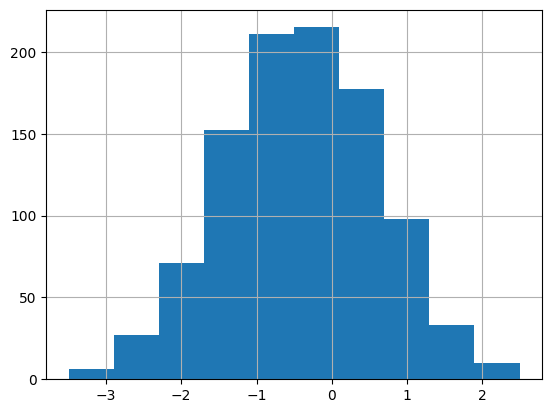

In [11]:
pd.Series(transformed_data).hist()

In [12]:
best_lambda

0.2539188969341096

Сходство квантилей с нормальным распределением, ММПП для подбора лямбды

# Отбор признаков

In [13]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]

In [14]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

Шум - случайный сигнал

## Корреляционный анализ

In [15]:
train_X.columns

Index(['back-suspension', 'battery-capacity', 'charge-time', 'compression',
       'consumption-mixed', 'cylinders-order', 'cylinders-value',
       'engine-feeding', 'engine-start', 'engine-stop', 'engine-type',
       'gear-type', 'luxury', 'max-speed', 'power-electro-kw', 'supply-system',
       'valves', 'valvetrain', 'weight', 'configurations_auto-premiere',
       'configurations_back-wheel-base', 'configurations_front-brake',
       'configurations_safety-rating', 'configurations_seats',
       'configurations_tank-volume', 'supergen_year-stop',
       'models_country-from', 'models_group', 'models_light-and-commercial',
       'models_male'],
      dtype='object')

In [16]:
train_X

,back-suspension,battery-capacity,charge-time,compression,consumption-mixed,cylinders-order,cylinders-value,engine-feeding,engine-start,engine-stop,...,configurations_back-wheel-base,configurations_front-brake,configurations_safety-rating,configurations_seats,configurations_tank-volume,supergen_year-stop,models_country-from,models_group,models_light-and-commercial,models_male
22607,3,-1.0,11636,9.5,-1.0,0,4,4,1997,2000,...,1415.0,4,2,13,50.0,2000.0,16,3,0,1
36531,8,-1.0,31764,9.0,-1.0,0,4,0,1990,1993,...,1310.0,1,2,13,48.0,1996.0,23,3,0,0
24048,8,-1.0,2773,8.8,6.8,0,4,4,2009,2012,...,1558.0,4,1,13,56.0,2012.0,10,3,0,1
34819,3,-1.0,52039,14.0,5.3,0,4,5,2015,2017,...,1590.0,4,2,13,56.0,2017.0,16,3,0,0
1328,3,-1.0,20689,18.0,7.5,0,5,5,2004,2005,...,1560.0,4,2,13,70.0,2009.0,28,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,6,-1.0,42729,16.5,4.7,0,4,5,2017,0,...,1630.0,4,2,13,68.0,-1.0,10,3,0,1
11284,0,-1.0,46093,8.1,-1.0,3,7,0,1987,1990,...,1486.0,4,2,13,82.0,1996.0,34,3,0,1
38158,3,-1.0,48819,10.0,7.6,0,4,2,2018,0,...,1636.0,4,2,13,62.0,-1.0,26,3,0,1
860,10,-1.0,9346,22.4,-1.0,0,4,6,1992,1995,...,1460.0,1,2,13,50.0,1995.0,16,3,0,1


In [17]:
ordinal = ['back-suspension', 'cylinders-order', 'engine-feeding', 'configurations_seats']
numerical = ['battery-capacity', 'charge-time', 'compression', 'consumption-mixed', 'cylinders-value', 'engine-start', 'engine-stop', 'luxury',
             'max-speed', 'power-electro-kw','valves','weight','configurations_auto-premiere','configurations_back-wheel-base','configurations_tank-volume',
             'supergen_year-stop']
catigorial = ['engine-type','gear-type', 'supply-system', 'valvetrain', 'configurations_front-brake', 'configurations_safety-rating','models_country-from',
              'models_group', 'models_light-and-commercial','models_male']

<Axes: xlabel='engine-type', ylabel='Count'>

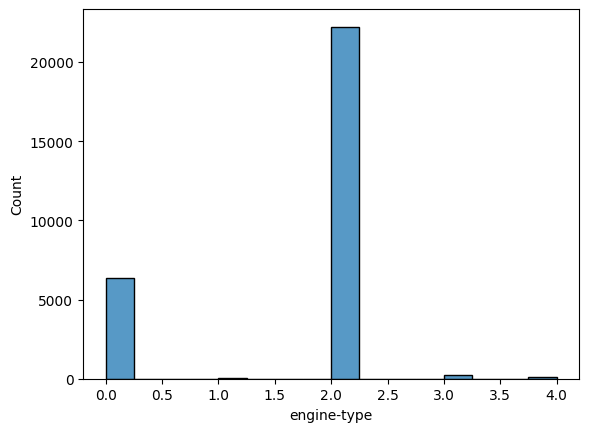

In [18]:
sns.histplot(data=train_X, x='engine-type')

In [19]:
#sns.pairplot(df) - не работает

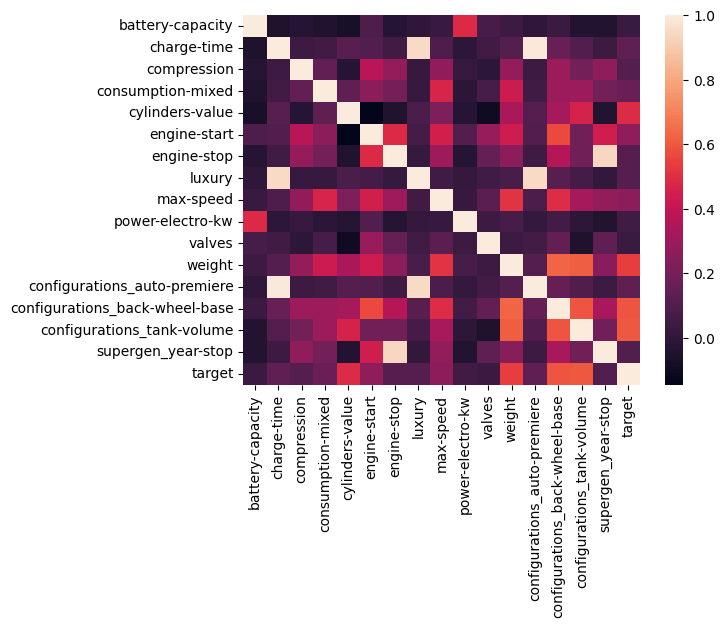

In [20]:
train = train_X
train['target'] = train_y
sns.heatmap(train[numerical + ['target']].corr(method='spearman'));

In [21]:
from scipy.stats import pearsonr, spearmanr

r = pearsonr(train['configurations_auto-premiere'], train['target'])
print('Pearson correlation:', r[0], 'p-value:', r[1])

Pearson correlation: 0.11003752360955571 p-value: 9.725646829197532e-79


In [22]:
r = pearsonr(train['battery-capacity'], train['target'])
print('Pearson correlation:', r[0], 'p-value:', r[1])

Pearson correlation: 0.023665183667100107 p-value: 5.6105473635706615e-05


## F-test

In [23]:
from sklearn.feature_selection import f_regression, SelectKBest

In [24]:
f_statistic, p_values = f_regression(train_X, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:358: RuntimeWarning: divide by zero encountered in true_divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


In [25]:
p_values

array([4.14261514e-178, 5.61054736e-005, 2.22583374e-084, 4.29215233e-006,
       5.19880608e-097, 0.00000000e+000, 0.00000000e+000, 3.00761649e-002,
       1.23407205e-153, 1.91780781e-122, 1.08128701e-102, 5.89170255e-038,
       1.18423856e-051, 6.73034264e-090, 6.04804785e-008, 3.29025321e-015,
       3.33873440e-033, 1.45689423e-002, 0.00000000e+000, 9.72564683e-079,
       6.46321123e-022, 5.15233301e-231, 8.63015515e-002, 0.00000000e+000,
       0.00000000e+000, 1.90641086e-122, 7.01981268e-140, 5.09638729e-005,
       4.56879391e-064, 3.51507643e-001, 0.00000000e+000])

In [26]:
sekector = SelectKBest(f_regression, k=20)
sekector.fit_transform(train_X, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:358: RuntimeWarning: divide by zero encountered in true_divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


array([[ 3.0000e+00,  1.1636e+04, -1.0000e+00, ...,  1.6000e+01,
         0.0000e+00,  2.4300e+03],
       [ 8.0000e+00,  3.1764e+04, -1.0000e+00, ...,  2.3000e+01,
         0.0000e+00,  2.4400e+03],
       [ 8.0000e+00,  2.7730e+03,  6.8000e+00, ...,  1.0000e+01,
         0.0000e+00,  2.6850e+03],
       ...,
       [ 3.0000e+00,  4.8819e+04,  7.6000e+00, ...,  2.6000e+01,
         0.0000e+00,  2.6700e+03],
       [ 1.0000e+01,  9.3460e+03, -1.0000e+00, ...,  1.6000e+01,
         0.0000e+00,  2.5000e+03],
       [ 3.0000e+00,  4.3309e+04, -1.0000e+00, ...,  3.5000e+01,
         0.0000e+00,  2.8800e+03]])

In [27]:
sekector.get_feature_names_out()

array(['back-suspension', 'charge-time', 'consumption-mixed',
       'cylinders-order', 'cylinders-value', 'engine-start',
       'engine-stop', 'engine-type', 'gear-type', 'luxury', 'max-speed',
       'weight', 'configurations_auto-premiere',
       'configurations_front-brake', 'configurations_seats',
       'configurations_tank-volume', 'supergen_year-stop',
       'models_country-from', 'models_light-and-commercial', 'target'],
      dtype=object)

множества: из данного множества можно составить подмножества в количестве 2^n

## Значения Шепли

In [28]:
import shap

In [29]:
reg = LinearRegression().fit(train_X, train_y)

In [30]:
#explainer = shap.Explainer(reg, train_X)
#shap_values = explainer(test_X)

In [31]:
#shap.summary_plot(shap_values, test_X)

Для признака cylinders-value наблюдается положительная статистическая зависимость от целевой переменной. Сравните Ваш результат с результатом работы библиотеки shap.

In [32]:
train_cut_X = train_X[train_X.columns[:5]]
test_cut_X = test_X[train_X.columns[:5]]

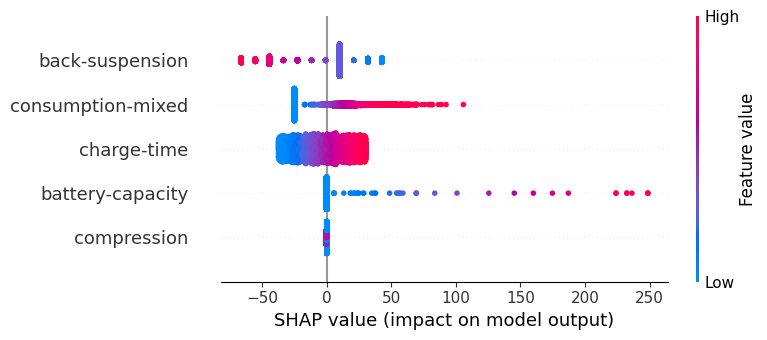

In [33]:
reg = LinearRegression().fit(train_cut_X, train_y)

explainer = shap.Explainer(reg, train_cut_X)
shap_values = explainer(test_cut_X)

shap.summary_plot(shap_values, test_cut_X)

### Задание

Для сокращенных данных (train_cut_X и test_cut_X) реализовать метод отбора важности признаков по Шепли.

In [34]:
train_cut_X

,back-suspension,battery-capacity,charge-time,compression,consumption-mixed
22607,3,-1.0,11636,9.5,-1.0
36531,8,-1.0,31764,9.0,-1.0
24048,8,-1.0,2773,8.8,6.8
34819,3,-1.0,52039,14.0,5.3
1328,3,-1.0,20689,18.0,7.5
...,...,...,...,...,...
6265,6,-1.0,42729,16.5,4.7
11284,0,-1.0,46093,8.1,-1.0
38158,3,-1.0,48819,10.0,7.6
860,10,-1.0,9346,22.4,-1.0


In [35]:
def create_subset(df, column_name):
    subset = []
    columns = df.columns
    for r in columns:
        if r != column_name:
            subset.append(r)
    
    return subset

In [36]:
S = list()
for col in train_X.columns:
    a = create_subset(train_X, col)
    S.append(a)
#S
#получаем подмножества из 30 колонок

In [37]:
N = train_cut_X.columns
N

Index(['back-suspension', 'battery-capacity', 'charge-time', 'compression',
       'consumption-mixed'],
      dtype='object')

In [38]:
shap = {}
for i in N:
    summ = 0
    for s in S:
        n = math.factorial(len(s)) * math.factorial(len(N)+len(s)) / math.factorial(len(N))
        fi = LinearRegression().fit(train_cut_X, train_y)
        predictionsi = fi.predict(test_cut_X)
        f_i = LinearRegression().fit(train_cut_X.drop(i, axis=1), train_y)
        predictions_i = f_i.predict(test_cut_X.drop(i, axis=1))
        r2i = r2_score(test_y, predictionsi)
        r2_i = r2_score(test_y, predictions_i)
        summ += n*(r2i - r2_i)
    shap[i] = summ
    print(i, ":", shap[i])

back-suspension : 9.689340362589442e+69
battery-capacity : 9.49414876854455e+68
charge-time : 4.012008468658736e+69
compression : 3.3904709971595e+66
consumption-mixed : 5.912571557802295e+69


## Пермутационная важность

In [39]:
import eli5
from eli5.sklearn import PermutationImportance

In [40]:
reg = LinearRegression().fit(train_cut_X, train_y)

In [41]:
perm = PermutationImportance(reg, random_state=42).fit(test_cut_X, test_y)

In [42]:
eli5.show_weights(perm, feature_names=list(test_cut_X.columns))

Weight,Feature
0.0310 ± 0.0033,back-suspension
0.0187 ± 0.0022,consumption-mixed
0.0118 ± 0.0021,charge-time
0.0026 ± 0.0001,battery-capacity
0.0000 ± 0.0000,compression


### Задание

Самостоятельно реализовать алгоритм отбора признаков на основе пермутационной важности. Построить гистограмму полученных значений.

In [43]:
reg = LinearRegression().fit(train_cut_X, train_y)

In [44]:
perm = {'factor': [], 'r2_i': []}
perm = pd.DataFrame(perm)

for i in N:
    test_cut_X_perm = test_cut_X
    test_cut_X_perm[i] = np.random.permutation(test_cut_X_perm[i].values)
    reg_new = LinearRegression().fit(test_cut_X_perm, test_y) 
    r2_i = r2_score(test_y, reg_new.predict(test_cut_X_perm))    
    column_index = test_cut_X_perm.columns.get_loc(i)
    perm.loc[column_index, 'r2_i'] = r2_i
    perm.loc[column_index, 'factor'] = i
    
perm.sort_values(by='r2_i', ascending=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,factor,r2_i
0,back-suspension,0.023244
1,battery-capacity,0.021776
3,compression,0.012261
2,charge-time,0.012133
4,consumption-mixed,0.000170


# Домашнее задание

Сгенерировать полиномиальные признаки для рассматриваегомого сегодня набора данных. Попробовать отобрать признаки различными методами (можно теми, что не рассматривали). Получить максимальное качество на тестовых данных. Проинтерпретировать результаты.

In [45]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")


In [46]:
df2 = df[['battery-capacity', 'charge-time', 'compression', 'consumption-mixed', 'cylinders-value', 'engine-start', 'engine-stop', 'luxury',
             'max-speed', 'power-electro-kw','valves','weight','configurations_auto-premiere','configurations_back-wheel-base','configurations_tank-volume',
             'supergen_year-stop', 'target']].copy()
df2

,battery-capacity,charge-time,compression,consumption-mixed,cylinders-value,engine-start,engine-stop,luxury,max-speed,power-electro-kw,valves,weight,configurations_auto-premiere,configurations_back-wheel-base,configurations_tank-volume,supergen_year-stop,target
0,-1.0,36457,9.0,4.3,3,2006,2018,36646,-1.0,-1.0,2,820.0,36479,1300.0,40.0,2018.0,2360
1,-1.0,44872,8.0,-1.0,7,1982,1993,44289,217.0,-1.0,1354,2350.0,44895,1555.0,108.0,1993.0,3060
2,-1.0,55927,16.0,4.2,4,2014,2018,55481,193.0,-1.0,2,1350.0,55963,1534.0,55.0,2019.0,2648
3,-1.0,41405,10.3,-1.0,4,2000,2003,40914,189.0,-1.0,0,1090.0,41425,1495.0,55.0,2003.0,2513
4,-1.0,22523,19.0,-1.0,4,2000,2005,22118,185.0,-1.0,0,1410.0,22491,1515.0,62.0,2005.0,2703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43240,-1.0,34558,11.2,6.6,4,2004,2016,34747,175.0,-1.0,2,-1.0,34570,1425.0,47.0,2016.0,2510
43241,-1.0,38268,9.6,5.8,4,2013,2015,37929,242.0,-1.0,2,1545.0,38286,1551.0,65.0,2015.0,2808
43242,-1.0,8958,10.0,9.3,4,1991,1999,8324,170.0,-1.0,2,1210.0,8903,1460.0,55.0,1999.0,2520
43243,-1.0,20293,8.5,-1.0,5,2002,2004,19806,250.0,-1.0,2,1660.0,20263,1548.0,70.0,2004.0,2755


In [47]:
X = df2.drop(["target"], axis=1)
y = df2[["target"]]

In [48]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [49]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly_features.fit_transform(train_X)
X_poly_test = poly_features.fit_transform(test_X)


In [50]:
X_poly_train = pd.DataFrame(data=X_poly_train)
X_poly_test = pd.DataFrame(data=X_poly_test)

In [51]:
X_poly_train

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,151
0,-1.0,11636.0,9.5,-1.0,4.0,1997.0,2000.0,11923.0,160.0,-1.0,...,1.355362e+08,16473430.0,582100.0,23284000.0,2002225.0,70750.0,2830000.0,2500.0,100000.0,4000000.0
1,-1.0,31764.0,9.0,-1.0,4.0,1990.0,1993.0,31915.0,145.0,-1.0,...,1.010286e+09,41638350.0,1525680.0,63442860.0,1716100.0,62880.0,2614760.0,2304.0,95808.0,3984016.0
2,-1.0,2773.0,8.8,6.8,4.0,2009.0,2012.0,2258.0,221.0,-1.0,...,7.634169e+06,4304754.0,154728.0,5559156.0,2427364.0,87248.0,3134696.0,3136.0,112672.0,4048144.0
3,-1.0,52039.0,14.0,5.3,4.0,2015.0,2017.0,51108.0,198.0,-1.0,...,2.712431e+09,82808790.0,2916536.0,105047377.0,2528100.0,89040.0,3207030.0,3136.0,112952.0,4068289.0
4,-1.0,20689.0,18.0,7.5,5.0,2004.0,2005.0,20228.0,195.0,-1.0,...,4.278692e+08,32268600.0,1447950.0,41556165.0,2433600.0,109200.0,3134040.0,4900.0,140630.0,4036081.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28969,-1.0,42729.0,16.5,4.7,4.0,2017.0,0.0,44681.0,230.0,-1.0,...,1.826879e+09,69669460.0,2906456.0,-42742.0,2656900.0,110840.0,-1630.0,4624.0,-68.0,1.0
28970,-1.0,46093.0,8.1,-1.0,7.0,1987.0,1990.0,46106.0,-1.0,-1.0,...,2.128069e+09,68550666.0,3782742.0,92077476.0,2208196.0,121852.0,2966056.0,6724.0,163672.0,3984016.0
28971,-1.0,48819.0,10.0,7.6,4.0,2018.0,0.0,48158.0,202.0,-1.0,...,2.387104e+09,79931688.0,3029196.0,-48858.0,2676496.0,101432.0,-1636.0,3844.0,-62.0,1.0
28972,-1.0,9346.0,22.4,-1.0,4.0,1992.0,1995.0,8757.0,-1.0,-1.0,...,8.858574e+07,13741520.0,470600.0,18776940.0,2131600.0,73000.0,2912700.0,2500.0,99750.0,3980025.0


In [52]:
reg = LinearRegression().fit(X_poly_train, train_y)

In [53]:
predictions = reg.predict(X_poly_test)


In [54]:
r2 = r2_score(test_y, predictions) 
r2

0.6116675851114588

In [55]:
mean_squared_error(reg.predict(X_poly_test), test_y)

22500.96808678516

In [56]:
mean_squared_error(reg.predict(X_poly_train), train_y)

21750.8908254748

### F-статистика

In [57]:
f_statistic, p_values = f_regression(X_poly_train, train_y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [58]:
p_values

array([5.61054736e-005, 2.22583374e-084, 4.29215233e-006, 5.19880608e-097,
       0.00000000e+000, 1.23407205e-153, 1.91780781e-122, 1.18423856e-051,
       6.73034264e-090, 6.04804785e-008, 3.33873440e-033, 0.00000000e+000,
       9.72564683e-079, 6.46321123e-022, 0.00000000e+000, 1.90641086e-122,
       1.04279598e-003, 5.13286284e-001, 1.18373649e-001, 1.63870545e-072,
       1.78677030e-162, 7.10099505e-005, 1.10327484e-009, 1.38194928e-001,
       4.37431047e-001, 2.77344634e-003, 2.07153073e-005, 5.62541201e-010,
       3.74889231e-001, 1.98948944e-002, 2.80255750e-187, 1.09938266e-011,
       9.49278405e-087, 2.02680119e-064, 2.14436854e-127, 0.00000000e+000,
       4.48409067e-087, 6.08446495e-007, 5.59008149e-064, 1.52561794e-143,
       1.58938191e-003, 6.98432123e-023, 0.00000000e+000, 1.37668031e-082,
       3.34978356e-109, 0.00000000e+000, 8.99252678e-006, 1.08674081e-015,
       6.58087371e-071, 2.19570795e-189, 1.18707494e-006, 2.75736463e-007,
       4.43683501e-044, 1

In [59]:
selector = SelectKBest(f_regression, k=20)
selector.fit_transform(X_poly_train, train_y)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


array([[ 4.000000e+00,  1.290000e+03,  5.000000e+01, ...,  5.821000e+05,
         7.075000e+04,  2.500000e+03],
       [ 4.000000e+00,  9.350000e+02,  4.800000e+01, ...,  1.525680e+06,
         6.288000e+04,  2.304000e+03],
       [ 4.000000e+00,  1.373000e+03,  5.600000e+01, ...,  1.547280e+05,
         8.724800e+04,  3.136000e+03],
       ...,
       [ 4.000000e+00,  1.562000e+03,  6.200000e+01, ...,  3.029196e+06,
         1.014320e+05,  3.844000e+03],
       [ 4.000000e+00, -1.000000e+00,  5.000000e+01, ...,  4.706000e+05,
         7.300000e+04,  2.500000e+03],
       [ 7.000000e+00,  1.745000e+03,  6.600000e+01, ...,  2.856810e+06,
         1.028940e+05,  4.356000e+03]])

In [60]:
train_x_F = pd.DataFrame(selector.fit_transform(X_poly_train, train_y), columns = selector.get_feature_names_out())
test_x_F = pd.DataFrame(selector.transform(X_poly_test), columns = selector.get_feature_names_out())

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [61]:
train_x_F

,x4,x11,x14,x42,x45,x74,x75,x81,x83,x84,x92,x95,x114,x137,x138,x139,x140,x144,x147,x149
0,4.0,1290.0,50.0,15010440.0,581800.0,16.0,7988.0,5160.0,5660.0,200.0,2576130.0,99850.0,596150.0,1664100.0,15018180.0,1825350.0,64500.0,582100.0,70750.0,2500.0
1,4.0,935.0,48.0,29699340.0,1524672.0,16.0,7960.0,3740.0,5240.0,192.0,1860650.0,95520.0,1531920.0,874225.0,29718975.0,1224850.0,44880.0,1525680.0,62880.0,2304.0
2,4.0,1373.0,56.0,3807329.0,155288.0,16.0,8036.0,5492.0,6232.0,224.0,2758357.0,112504.0,126448.0,1885129.0,3793599.0,2139134.0,76888.0,154728.0,87248.0,3136.0
3,4.0,1430.0,56.0,74415770.0,2914184.0,16.0,8060.0,5720.0,6360.0,224.0,2881450.0,112840.0,2862048.0,2044900.0,74475830.0,2273700.0,80080.0,2916536.0,89040.0,3136.0
4,5.0,1485.0,70.0,30723165.0,1448230.0,25.0,10020.0,7425.0,7800.0,350.0,2975940.0,140280.0,1415960.0,2205225.0,30717225.0,2316600.0,103950.0,1447950.0,109200.0,4900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28969,4.0,1655.0,68.0,70716495.0,2905572.0,16.0,8068.0,6620.0,6520.0,272.0,3338135.0,137156.0,3038308.0,2739025.0,70738010.0,2697650.0,112540.0,2906456.0,110840.0,4624.0
28970,7.0,-1.0,82.0,-46093.0,3779626.0,49.0,13909.0,-7.0,10402.0,574.0,-1987.0,162934.0,3780692.0,1.0,-46131.0,-1486.0,-82.0,3782742.0,121852.0,6724.0
28971,4.0,1562.0,62.0,76255278.0,3026778.0,16.0,8072.0,6248.0,6544.0,248.0,3152116.0,125116.0,2985796.0,2439844.0,76316196.0,2555432.0,96844.0,3029196.0,101432.0,3844.0
28972,4.0,-1.0,50.0,-9346.0,467300.0,16.0,7968.0,-4.0,5840.0,200.0,-1992.0,99600.0,437850.0,1.0,-9412.0,-1460.0,-50.0,470600.0,73000.0,2500.0


In [62]:
reg_new = LinearRegression().fit(train_x_F , train_y)


In [63]:
predictions = reg_new.predict(test_x_F)


In [64]:
r2 = r2_score(test_y, predictions) 
r2

0.5265507367852269

In [65]:
mean_squared_error(reg_new.predict(train_x_F), train_y)

26556.281186841697

In [66]:
mean_squared_error(reg_new.predict(test_x_F), test_y)

27432.854827133582

In [67]:
sns.heatmap(train_x.corr(method='spearman'))

NameError: name 'train_x' is not defined

Слишком большое количество мультиколлинеарных факторов. Также заметим уменьшение R^2 при увеличении MSE.

### Шепли

In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(reg, X_poly_train)
shap_values = explainer(X_poly_test)

In [ ]:
shap.summary_plot(shap_values, X_poly_test)

### Пермутационная важность

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [68]:
perm = PermutationImportance(reg, random_state=42).fit(X_poly_test, test_y)

In [69]:
eli5.show_weights(perm)

Weight,Feature
1467.7526 ± 28.1491,x86
1445.7218 ± 18.6614,x5
225.7405 ± 3.8275,x94
191.6350 ± 1.4787,x96
177.2826 ± 1.6737,x13
89.4186 ± 1.0231,x15
70.2055 ± 1.1135,x95
68.8302 ± 1.1607,x14
66.2937 ± 1.0432,x3
60.7965 ± 0.2684,x63


In [70]:
X_poly_test_shap = X_poly_test[[86, 5, 94, 96, 13, 15, 95, 14, 3, 63, 89, 87, 8, 4, 88]].copy()

In [71]:
X_poly_train_shap = X_poly_train[[86, 5, 94, 96, 13, 15, 95, 14, 3, 63, 89, 87, 8, 4, 88]].copy()

In [72]:
reg = LinearRegression().fit(X_poly_train_shap , train_y)

In [73]:
predictions = reg.predict(X_poly_test_shap)

In [74]:
r2 = r2_score(test_y, predictions) 
r2

0.42168261343075264

In [75]:
mean_squared_error(reg.predict(X_poly_train_shap), train_y)

32603.349955176833

In [76]:
mean_squared_error(reg.predict(X_poly_test_shap), test_y)

33509.180692429516

Результаты также ухудшились

In [77]:
X_poly_test_shap = X_poly_test[[3, 4, 5, 8, 11, 13, 14, 15, 42, 45, 63, 74, 75, 81, 83, 84, 86, 87, 88, 89, 92, 94, 95, 96, 114, 137, 138, 139, 140, 144, 147, 149]].copy()

In [78]:
X_poly_train_shap = X_poly_train[[3, 4, 5, 8, 11, 13, 14, 15, 42, 45, 63, 74, 75, 81, 83, 84, 86, 87, 88, 89, 92, 94, 95, 96, 114, 137, 138, 139, 140, 144, 147, 149]].copy()

In [79]:
reg = LinearRegression().fit(X_poly_train_shap , train_y)

In [80]:
predictions = reg.predict(X_poly_test_shap)

In [81]:
r2 = r2_score(test_y, predictions) 
r2

0.5603064987546831

In [82]:
mean_squared_error(reg.predict(X_poly_train_shap), train_y)

24712.40139845301

In [83]:
mean_squared_error(reg.predict(X_poly_test_shap), test_y)

25476.96009957691

По сравнению с изначальным вариантом особых улучшений нет. Также наблюдается мультиколлинеарность.

Можно попытаться избавиться от мультиколлинеарности, но тогда страдает качество модели:

In [84]:
X_poly_test_shap = X_poly_test[[63, 86, 88, 89, 94, 95]].copy()

In [85]:
X_poly_train_shap = X_poly_train[[63, 86, 88, 89, 94, 95]].copy()

In [86]:
reg = LinearRegression().fit(X_poly_train_shap , train_y)

In [87]:
predictions = reg.predict(X_poly_test_shap)

In [88]:
r2 = r2_score(test_y, predictions) 
r2

0.20335033511194567

In [89]:
mean_squared_error(reg.predict(X_poly_train_shap), train_y)

44179.242020868456

In [90]:
mean_squared_error(reg.predict(X_poly_test_shap), test_y)

46159.90836391841

<Axes: >

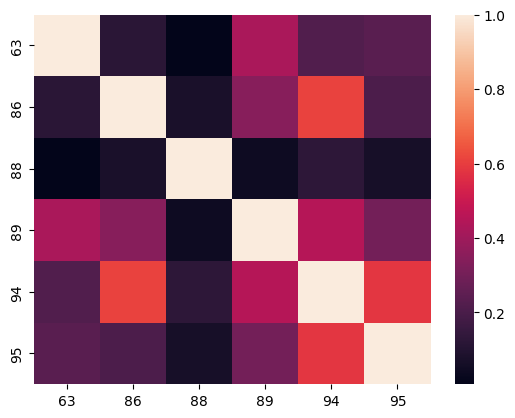

In [91]:
sns.heatmap(X_poly_train_shap.corr(method='spearman'))

In [92]:
train_x_F['x86'] = X_poly_train[86]
train_x_F['x5'] = X_poly_train[5]
train_x_F

,x4,x11,x14,x42,x45,x74,x75,x81,x83,x84,...,x114,x137,x138,x139,x140,x144,x147,x149,x86,x5
0,4.0,1290.0,50.0,15010440.0,581800.0,16.0,7988.0,5160.0,5660.0,200.0,...,596150.0,1664100.0,15018180.0,1825350.0,64500.0,582100.0,70750.0,2500.0,3988009.0,1997.0
1,4.0,935.0,48.0,29699340.0,1524672.0,16.0,7960.0,3740.0,5240.0,192.0,...,1531920.0,874225.0,29718975.0,1224850.0,44880.0,1525680.0,62880.0,2304.0,3960100.0,1990.0
2,4.0,1373.0,56.0,3807329.0,155288.0,16.0,8036.0,5492.0,6232.0,224.0,...,126448.0,1885129.0,3793599.0,2139134.0,76888.0,154728.0,87248.0,3136.0,4036081.0,2009.0
3,4.0,1430.0,56.0,74415770.0,2914184.0,16.0,8060.0,5720.0,6360.0,224.0,...,2862048.0,2044900.0,74475830.0,2273700.0,80080.0,2916536.0,89040.0,3136.0,4060225.0,2015.0
4,5.0,1485.0,70.0,30723165.0,1448230.0,25.0,10020.0,7425.0,7800.0,350.0,...,1415960.0,2205225.0,30717225.0,2316600.0,103950.0,1447950.0,109200.0,4900.0,4016016.0,2004.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28969,4.0,1655.0,68.0,70716495.0,2905572.0,16.0,8068.0,6620.0,6520.0,272.0,...,3038308.0,2739025.0,70738010.0,2697650.0,112540.0,2906456.0,110840.0,4624.0,4068289.0,2017.0
28970,7.0,-1.0,82.0,-46093.0,3779626.0,49.0,13909.0,-7.0,10402.0,574.0,...,3780692.0,1.0,-46131.0,-1486.0,-82.0,3782742.0,121852.0,6724.0,3948169.0,1987.0
28971,4.0,1562.0,62.0,76255278.0,3026778.0,16.0,8072.0,6248.0,6544.0,248.0,...,2985796.0,2439844.0,76316196.0,2555432.0,96844.0,3029196.0,101432.0,3844.0,4072324.0,2018.0
28972,4.0,-1.0,50.0,-9346.0,467300.0,16.0,7968.0,-4.0,5840.0,200.0,...,437850.0,1.0,-9412.0,-1460.0,-50.0,470600.0,73000.0,2500.0,3968064.0,1992.0


In [93]:
test_x_F['x86'] = X_poly_test[86]
test_x_F['x5'] = X_poly_test[5]
test_x_F

,x4,x11,x14,x42,x45,x74,x75,x81,x83,x84,...,x114,x137,x138,x139,x140,x144,x147,x149,x86,x5
0,4.0,-1.0,-1.0,-6384.0,-6384.0,16.0,7936.0,-4.0,6108.0,-4.0,...,-5925.0,1.0,-1267.0,-1527.0,1.0,-1267.0,-1527.0,1.0,3936256.0,1984.0
1,6.0,-1.0,-1.0,-5682.0,-5682.0,36.0,11862.0,-6.0,9060.0,-6.0,...,-5205.0,1.0,-5717.0,-1510.0,1.0,-5717.0,-1510.0,1.0,3908529.0,1977.0
2,4.0,1163.0,45.0,18363770.0,710550.0,16.0,8048.0,4652.0,5912.0,180.0,...,690525.0,1352569.0,18385867.0,1718914.0,52335.0,711405.0,66510.0,2025.0,4048144.0,2012.0
3,3.0,760.0,37.0,27989280.0,1362636.0,9.0,5961.0,2280.0,-3.0,111.0,...,1348243.0,577600.0,27987000.0,-760.0,28120.0,1362525.0,-37.0,1369.0,3948169.0,1987.0
4,4.0,1425.0,70.0,55691850.0,2735740.0,16.0,8016.0,5700.0,6056.0,280.0,...,2701020.0,2030625.0,55720350.0,2157450.0,99750.0,2737140.0,105980.0,4900.0,4016016.0,2004.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14266,4.0,1170.0,60.0,14423760.0,739680.0,16.0,7960.0,4680.0,5800.0,240.0,...,706680.0,1368900.0,14433120.0,1696500.0,70200.0,740160.0,87000.0,3600.0,3960100.0,1990.0
14267,4.0,990.0,60.0,47432880.0,2874720.0,16.0,7956.0,3960.0,5720.0,240.0,...,2840100.0,980100.0,47379420.0,1415700.0,59400.0,2871480.0,85800.0,3600.0,3956121.0,1989.0
14268,4.0,990.0,40.0,23571900.0,952400.0,16.0,8012.0,3960.0,5120.0,160.0,...,933640.0,980100.0,23272920.0,1267200.0,39600.0,940320.0,51200.0,1600.0,4012009.0,2003.0
14269,4.0,-1.0,65.0,-23486.0,1526590.0,16.0,8008.0,-4.0,5860.0,260.0,...,1519440.0,1.0,-23543.0,-1465.0,-65.0,1530295.0,95225.0,4225.0,4008004.0,2002.0


In [94]:
reg = LinearRegression().fit(train_x_F , train_y)

In [95]:
predictions = reg.predict(test_x_F)

In [96]:
r2 = r2_score(test_y, predictions) 
r2

0.5556265540625993

In [97]:
mean_squared_error(reg.predict(train_x_F), train_y)

25030.830638827956

In [98]:
mean_squared_error(reg.predict(test_x_F), test_y)

25748.12800142388

В данную модель включены параметры, отобранные через F, 2 верхник параметра из Шепли (они же ярко подсвечены в пермутационной важности).

<Axes: >

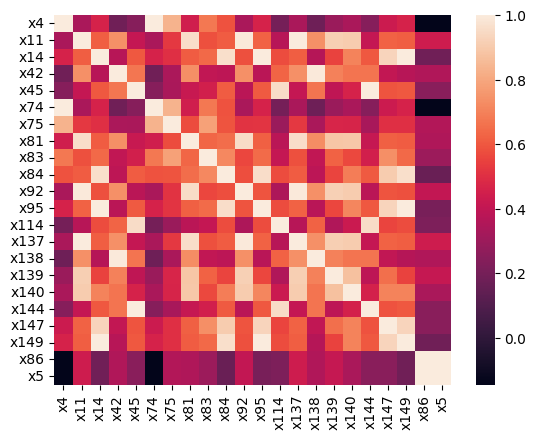

In [99]:
sns.heatmap(train_x_F.corr(method='spearman'))